# Debiasing italian word embeddings

### Downlaod data 
First of all, you need to download the Italian web corpus (itWaC) embeddings, an Italian corpus made up of texts collected from the Internet, from the following link [here](https://drive.google.com/file/d/1eq2Ehc8Tpj_9oFPVSFdZ1aN9YJm7J55s/view?usp=sharing) and insert the file into the `embeddings` folder.

In [4]:
from matplotlib import pyplot as plt
import numpy as np

import debiaswe.we as we
from debiaswe.we import WordEmbedding

import tqdm

## 1. Analysis of the embeddings

In [2]:
# load the word embeddings
E = WordEmbedding('./embeddings/filtered_itwac128.tsv')

*** Reading data from ./embeddings/filtered_itwac128.tsv
(537325, 128)
537325 words of dimension 128 : di, e, che, la, ..., checcosf, dacris, pawprint, eorismo


### 1.1 Define gender direction

We define gender direction by the pricipal component of 6 directions extracted from specific gender pairs like `"lei"-"lui"`, `"donna"-"uomo"`, etc., that largely captures gender in the embedding. This direction helps us to quantify direct and indirect biases in words and associations.

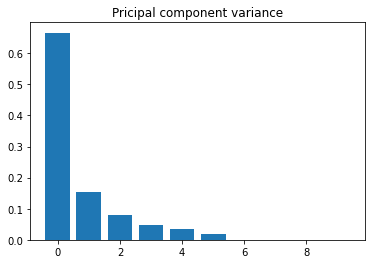

In [12]:
# compute gender direction
female_definitional = ["lei", "donna", "madre", "moglie", "sorella", "femmina"]
male_definitional = ["lui", "uomo", "padre", "marito", "fratello", "maschio"]
gender_definitional_pairs = list(zip(male_definitional, female_definitional))

gender_direction = we.doPCA(gender_definitional_pairs, E).components_[0]

# plot variance
plt.bar(range(10), we.doPCA(gender_definitional_pairs, E).explained_variance_ratio_)
plt.title("Pricipal component variance")
plt.show()

### 1.2 Exploit relations between words computing analogies

In [36]:
from scipy.spatial import distance
def analogy(positive1, negative1, positive2, embedding, ntop=10):
    relationship_1 = embedding.v(positive1) - embedding.v(negative1)
    relationship_2 = [embedding.v(positive2) - embedding.v(word) for word in embedding.words]

    similarities = {i: distance.cosine(relationship_1, rel2) for i, rel2 in enumerate(relationship_2)}

    # sort similarities by value
    similarities = dict(sorted(similarities.items(), key=lambda x: x[1]))

    idx_to_word = {i: w for w, i in embedding.index.items()}
    return [(idx_to_word[i], value) for i, value in list(similarities.items())[:ntop]]

print("Most similar:") 
analogy(positive1="parigi", negative1="francia", positive2="roma", embedding=E, ntop=10)

Most similar:


C:\Users\peppe\anaconda3\envs\nlp\lib\site-packages\scipy\spatial\distance.py:630: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('roma', 0),
 ('francia', 0.3229256272315979),
 ('italia', 0.42631858587265015),
 ('germania', 0.4459470510482788),
 ('europa', 0.5026416480541229),
 ('svezia', 0.506334513425827),
 ('secundis', 0.5192542672157288),
 ('korea', 0.5282283425331116),
 ('america', 0.5477666258811951),
 ('soka', 0.5480005145072937)]

In [24]:
# most similar words
E.more_words_like_these(["comunicazione"], topn = 10, max_freq=len(E.words))[1:]

['comunicazione',
 'informazione',
 'trasmissione',
 'consultazione',
 'veicolazione',
 'ricezione',
 'conoscenza',
 'pubblicizzazione',
 'diffusione',
 'divulgazione']